# Estabelece a absorção de demanda pelos aeroportos mapeados com base na matriz de origem-destino

In [30]:
import pandas as pd
import geopandas as gpd

In [2]:
matriz_od_completa = pd.read_csv('data/csv/matriz_od_completa.csv', delimiter = ',')

In [3]:
cat_influencia = pd.read_excel('data/excel/xlsx/cat_influencia_geral.xlsx', engine='openpyxl')

In [14]:
id_aeroporto = pd.read_excel('data/excel/xlsx/id_aeroporto_v2.xlsx', engine='openpyxl')

In [4]:
cat_absorcao = pd.read_excel('data/excel/xlsx/cat_absorcao_nacional.xlsx', engine='openpyxl')

In [45]:
municipios_geo = gpd.read_file('data/shapefile/centroide/municipios_centroide.shp')

In [47]:
def converter_geodf_para_df(gdf):
    df = gdf[['CD_MUN', 'geometry']].copy()
    df.rename(columns={'CD_MUN': 'cod_mun'}, inplace=True)
    df['coord'] = df['geometry'].apply(lambda point: f"[{point.y},{point.x}]")
    return df[['cod_mun', 'coord']]

# Aplicando a função para converter o GeoDataFrame municipios
municipios = converter_geodf_para_df(municipios_geo)

In [5]:
piar_aeroportos = ['SBTE - TERESINA', 'SBPB - PARNAÍBA', 'SWKQ - SÃO RAIMUNDO NONATO','SBFZ - FORTALEZA','SNBR - BARREIRAS','SBSL - SÃO LUÍS','SBBR - BRASÍLIA']

In [217]:
def filtrar_aeroportos_por_id(df, ids_validos):
    df_filtrado = df[df['ID_AEROPORTO'].isin(ids_validos)].copy()
    df_filtrado['coord'] = df_filtrado.apply(lambda x: f"[{x['LATITUDE']},{x['LONGITUDE']}]", axis=1)
    df_filtrado = df_filtrado.rename(columns={'ID_AEROPORTO': 'id_aeroporto', 'PASSAGEIROS_ULTIMO_ANO': 'passageiros_ano'})
    return df_filtrado[['id_aeroporto', 'coord', 'passageiros_ano']]

# Aplicando o filtro para criar o DataFrame id_aeroporto_piar
id_aeroporto_piar = filtrar_aeroportos_por_id(id_aeroporto, piar_aeroportos)

In [6]:
def filtrar_aeroportos(df, aeroportos, cat_absorcao):
    # Mantém as três primeiras colunas como índice
    colunas_indice = df.columns[:3]
    
    # Filtra as colunas que correspondem ao id_aeroporto na lista 'aeroportos'
    df_filtrado = df.loc[:, df.columns.isin(aeroportos) | df.columns.isin(colunas_indice)]
    
    # Filtra as linhas onde todas as colunas a partir da quarta são iguais a 'M'
    colunas_para_verificar = df_filtrado.columns[3:]  # As colunas a partir da quarta
    
    # Filtra as linhas onde todos os valores dessas colunas são 'M'
    df_filtrado = df_filtrado[~df_filtrado[colunas_para_verificar].eq('M').all(axis=1)]
    
    # Substituir valores categóricos pelas médias equivalentes em cat_absorcao
    categoria_para_absorcao = dict(zip(cat_absorcao['categoria'], cat_absorcao['absorcao']))
    df_filtrado[colunas_para_verificar] = df_filtrado[colunas_para_verificar].replace(categoria_para_absorcao)
    
    # Substituir 'M' restantes por 0
    df_filtrado[colunas_para_verificar] = df_filtrado[colunas_para_verificar].replace('M', 0)
    
    # Retorna o novo DataFrame filtrado
    return df_filtrado

cat_influencia_piar = filtrar_aeroportos(cat_influencia, piar_aeroportos, cat_absorcao)

In [7]:

def criar_rotas_combinadas():
    # Dados para cada rota
    dados = {
        'rota_a_cenario_1': {
            'rota': 'A',
            'cenario': '1',
            'aero_origem': [
                'SBPB - PARNAÍBA', 'SBTE - TERESINA', 'SWKQ - SÃO RAIMUNDO NONATO',
                'SBBR - BRASÍLIA', 'SWKQ - SÃO RAIMUNDO NONATO', 'SBTE - TERESINA',
                'SBPB - PARNAÍBA', 'SBTE - TERESINA', 'SBPB - PARNAÍBA',
                'SBBR - BRASÍLIA', 'SBBR - BRASÍLIA', 'SWKQ - SÃO RAIMUNDO NONATO'
            ],
            'aero_destino': [
                'SBTE - TERESINA', 'SWKQ - SÃO RAIMUNDO NONATO', 'SBBR - BRASÍLIA',
                'SWKQ - SÃO RAIMUNDO NONATO', 'SBTE - TERESINA', 'SBPB - PARNAÍBA',
                'SBBR - BRASÍLIA', 'SBBR - BRASÍLIA', 'SWKQ - SÃO RAIMUNDO NONATO',
                'SBPB - PARNAÍBA', 'SBTE - TERESINA', 'SBPB - PARNAÍBA'
            ]
        },
        'rota_a_cenario_2': {
            'rota': 'A',
            'cenario': '2',
            'aero_origem': [
                'SBPB - PARNAÍBA', 'SBTE - TERESINA', 'SNBR - BARREIRAS',
                'SBBR - BRASÍLIA', 'SNBR - BARREIRAS', 'SBTE - TERESINA',
                'SBPB - PARNAÍBA', 'SBTE - TERESINA', 'SBPB - PARNAÍBA',
                'SBBR - BRASÍLIA', 'SBBR - BRASÍLIA', 'SNBR - BARREIRAS'
            ],
            'aero_destino': [
                'SBTE - TERESINA', 'SNBR - BARREIRAS', 'SBBR - BRASÍLIA',
                'SNBR - BARREIRAS', 'SBTE - TERESINA', 'SBPB - PARNAÍBA',
                'SBBR - BRASÍLIA', 'SBBR - BRASÍLIA', 'SNBR - BARREIRAS',
                'SBPB - PARNAÍBA', 'SBTE - TERESINA', 'SBPB - PARNAÍBA'
            ]
        },
        'rota_b_cenario_1': {
            'rota': 'B',
            'cenario': '1',
            'aero_origem': [
                'SBPB - PARNAÍBA', 'SBSL - SÃO LUÍS', 'SBTE - TERESINA',
                'SBFZ - FORTALEZA', 'SBTE - TERESINA', 'SBSL - SÃO LUÍS',
                'SBPB - PARNAÍBA', 'SBSL - SÃO LUÍS', 'SBTE - TERESINA',
                'SBFZ - FORTALEZA'
            ],
            'aero_destino': [
                'SBSL - SÃO LUÍS', 'SBTE - TERESINA', 'SBFZ - FORTALEZA',
                'SBTE - TERESINA', 'SBSL - SÃO LUÍS', 'SBPB - PARNAÍBA',
                'SBTE - TERESINA', 'SBFZ - FORTALEZA', 'SBPB - PARNAÍBA',
                'SBSL - SÃO LUÍS'
            ]
        },
        'rota_b_cenario_2': {
            'rota': 'B',
            'cenario': '2' ,
            'aero_origem': [
                'SBPB - PARNAÍBA', 'SBFZ - FORTALEZA', 'SBTE - TERESINA',
                'SBSL - SÃO LUÍS', 'SBTE - TERESINA', 'SBFZ - FORTALEZA',
                'SBPB - PARNAÍBA', 'SBSL - SÃO LUÍS', 'SBTE - TERESINA',
                'SBFZ - FORTALEZA'
            ],
            'aero_destino': [
                'SBFZ - FORTALEZA', 'SBTE - TERESINA', 'SBSL - SÃO LUÍS',
                'SBTE - TERESINA', 'SBFZ - FORTALEZA', 'SBPB - PARNAÍBA',
                'SBTE - TERESINA', 'SBFZ - FORTALEZA', 'SBPB - PARNAÍBA',
                'SBSL - SÃO LUÍS'
            ]
        }
    }

    # Criar os DataFrames e adicionar as colunas 'rota' e 'cenario'
    rotas = []
    for nome, dados_rotas in dados.items():
        df = pd.DataFrame(dados_rotas)
        rotas.append(df)
    
    # Concatenar todos os DataFrames em um único DataFrame
    rotas_combinadas = pd.concat(rotas, ignore_index=True)
    
    return rotas_combinadas

# Criar o DataFrame combinado
rotas_combinadas = criar_rotas_combinadas()

In [8]:
# Criando o DataFrame 'matriz_od_piar' com o filtro
def filtrar_matriz_od(matriz_od_completa, cat_influencia_piar):
    # Lista de municípios de influência
    municipios_influencia = cat_influencia_piar['CD_MUN']
    
    # Aplicando o filtro
    matriz_od_piar = matriz_od_completa[
        (matriz_od_completa['mun_origem'].isin(municipios_influencia)) &
        (matriz_od_completa['mun_destino'].isin(municipios_influencia))
    ]

    # Colunas a serem removidas
    colunas_remover = [
        'pib_origem', 'pib_destino', 'turismo_origem', 'turismo_destino',
        'pib_per_capita_origem', 'pib_per_capita_destino', 'classe_distancia',
        'classe_pop_origem', 'classe_pop_destino'
    ]
    
    # Removendo as colunas especificadas
    matriz_od_piar = matriz_od_piar.drop(columns=colunas_remover, errors='ignore')
    
    return matriz_od_piar

matriz_od_piar = filtrar_matriz_od(matriz_od_completa, cat_influencia_piar)

In [9]:
def adicionar_qtde_mun(rotas_combinadas, cat_influencia_piar):
    # Função para contar os valores > 0 em uma coluna correspondente a um aeroporto
    def contar_mun(aeroporto, matriz_influencia):
        # Procurar a correspondência no cabeçalho (nomes das colunas)
        if aeroporto in matriz_influencia.columns:
            # Contar quantas linhas têm valor maior que 0 na coluna correspondente
            return (matriz_influencia[aeroporto] > 0).sum()
        else:
            return 0

    # Adicionar a coluna qtde_mun_origem
    rotas_combinadas['qtde_mun_origem'] = rotas_combinadas['aero_origem'].apply(
        lambda x: contar_mun(x, cat_influencia_piar)
    )
    
    # Adicionar a coluna qtde_mun_destino
    rotas_combinadas['qtde_mun_destino'] = rotas_combinadas['aero_destino'].apply(
        lambda x: contar_mun(x, cat_influencia_piar)
    )
    
    return rotas_combinadas

# Atualizando o DataFrame rotas_combinadas com as novas colunas
rotas_combinadas = adicionar_qtde_mun(rotas_combinadas, cat_influencia_piar)

In [53]:
def expandir_rotas_combinadas(rotas_combinadas, cat_influencia_piar):
    # Lista para armazenar as linhas expandidas
    linhas_expandidas = []

    for index, row in rotas_combinadas.iterrows():
        # Identificar coluna no cabeçalho para 'aero_origem' e 'aero_destino'
        col_origem = row['aero_origem']
        col_destino = row['aero_destino']

        if col_origem in cat_influencia_piar.columns and col_destino in cat_influencia_piar.columns:
            # Criar data frames temporários para valores maiores que 0
            temp_origem = cat_influencia_piar[cat_influencia_piar[col_origem] > 0][['CD_MUN', col_origem]]
            temp_destino = cat_influencia_piar[cat_influencia_piar[col_destino] > 0][['CD_MUN', col_destino]]

            # Criar combinações entre os pares de municípios, excluindo combinações iguais
            for _, origem_row in temp_origem.iterrows():
                for _, destino_row in temp_destino.iterrows():
                    if origem_row['CD_MUN'] != destino_row['CD_MUN']:
                        linhas_expandidas.append({
                            'rota': row['rota'],
                            'cenario': row['cenario'],
                            'aero_origem': row['aero_origem'],
                            'aero_destino': row['aero_destino'],
                            'mun_origem': origem_row['CD_MUN'],
                            'mun_destino': destino_row['CD_MUN'],
                            'absorcao_origem': origem_row[col_origem],
                            'absorcao_destino': destino_row[col_destino]
                        })
        
        print(f"Par de aeroportos ({row['aero_origem']}, {row['aero_destino']}) completado.")

    # Criar DataFrame a partir das linhas expandidas
    rotas_expandidas = pd.DataFrame(linhas_expandidas)
    return rotas_expandidas

# Expandindo o DataFrame rotas_combinadas
rotas_expandidas = expandir_rotas_combinadas(rotas_combinadas, cat_influencia_piar)

Par de aeroportos (SBPB - PARNAÍBA, SBTE - TERESINA) completado.
Par de aeroportos (SBTE - TERESINA, SWKQ - SÃO RAIMUNDO NONATO) completado.
Par de aeroportos (SWKQ - SÃO RAIMUNDO NONATO, SBBR - BRASÍLIA) completado.
Par de aeroportos (SBBR - BRASÍLIA, SWKQ - SÃO RAIMUNDO NONATO) completado.
Par de aeroportos (SWKQ - SÃO RAIMUNDO NONATO, SBTE - TERESINA) completado.
Par de aeroportos (SBTE - TERESINA, SBPB - PARNAÍBA) completado.
Par de aeroportos (SBPB - PARNAÍBA, SBBR - BRASÍLIA) completado.
Par de aeroportos (SBTE - TERESINA, SBBR - BRASÍLIA) completado.
Par de aeroportos (SBPB - PARNAÍBA, SWKQ - SÃO RAIMUNDO NONATO) completado.
Par de aeroportos (SBBR - BRASÍLIA, SBPB - PARNAÍBA) completado.
Par de aeroportos (SBBR - BRASÍLIA, SBTE - TERESINA) completado.
Par de aeroportos (SWKQ - SÃO RAIMUNDO NONATO, SBPB - PARNAÍBA) completado.
Par de aeroportos (SBPB - PARNAÍBA, SBTE - TERESINA) completado.
Par de aeroportos (SBTE - TERESINA, SNBR - BARREIRAS) completado.
Par de aeroportos (SNBR

In [146]:
def adicionar_dados_matriz_od(rotas_expandidas, matriz_od_piar):
    # Renomeando a coluna 'distancia' em matriz_od_piar para 'distancia_mun'
    matriz_od_piar_renomeada = matriz_od_piar.rename(columns={'distancia': 'distancia_mun_mun'})
    
    # Fazendo o merge com base em mun_origem e mun_destino
    rotas_atualizadas = pd.merge(
        rotas_expandidas,
        matriz_od_piar_renomeada[['mun_origem', 'mun_destino', 'distancia_mun_mun', 'demanda_total_previsto',
                                  'share_aero_previsto', 'demanda_aerea_previsto']],
        on=['mun_origem', 'mun_destino'],
        how='left'
    )
    
    return rotas_atualizadas

# Atualizando o DataFrame rotas_expandidas com os dados de matriz_od_piar
matriz_od_piar_revisado = adicionar_dados_matriz_od(rotas_expandidas, matriz_od_piar)

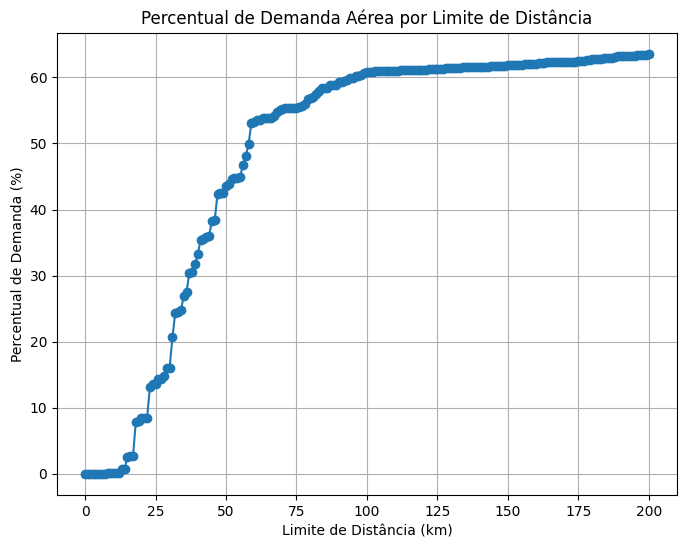

In [147]:
import matplotlib.pyplot as plt

# Definição dos valores globais
INICIO = 0
FIM = 200
PASSO = 1

def gerar_grafico_percentual_demanda_proximidade(matriz_od):
    # Definição da função para calcular o percentual
    def calcular_percentual_demanda(matriz_od, limite_distancia):
        demanda_total = matriz_od['demanda_aerea_previsto'].sum()
        demanda_filtrada = matriz_od[matriz_od['distancia_mun_mun'] <= limite_distancia]['demanda_aerea_previsto'].sum()
        percentual = (demanda_filtrada / demanda_total) * 100 if demanda_total > 0 else 0
        return percentual

    # Intervalos de limite de distância
    limites_distancia = range(INICIO, FIM + 1, PASSO)

    # Calculando percentuais para cada limite de distância
    percentuais_demanda = [calcular_percentual_demanda(matriz_od, limite) for limite in limites_distancia]

    # Plotando o gráfico
    plt.figure(figsize=(8, 6))
    plt.plot(limites_distancia, percentuais_demanda, marker='o', linestyle='-')
    plt.title('Percentual de Demanda Aérea por Limite de Distância')
    plt.xlabel('Limite de Distância (km)')
    plt.ylabel('Percentual de Demanda (%)')
    plt.grid()

    # Exibir o gráfico
    plt.show()

# Chamada da função
gerar_grafico_percentual_demanda_proximidade(matriz_od_piar_revisado)

In [148]:
def filtrar_por_distancia(dataframe):
    # Filtrando o DataFrame
    dataframe_filtrado = dataframe[dataframe['distancia_mun_mun'] > 200]
        
    return dataframe_filtrado

# Exemplo de uso
matriz_od_piar_revisado = filtrar_por_distancia(matriz_od_piar_revisado)

In [149]:
def adicionar_coordenadas(rotas_df, aeroportos_df, municipios_df):
    # Garantindo que os códigos sejam numéricos sem decimais
    rotas_df['mun_origem'] = pd.to_numeric(rotas_df['mun_origem'], errors='coerce').astype('Int64')
    rotas_df['mun_destino'] = pd.to_numeric(rotas_df['mun_destino'], errors='coerce').astype('Int64')
    municipios_df['cod_mun'] = pd.to_numeric(municipios_df['cod_mun'], errors='coerce').astype('Int64')
    
    # Mapeando coordenadas de aeroportos
    coord_aero_origem = rotas_df['aero_origem'].map(
        dict(zip(aeroportos_df['id_aeroporto'], aeroportos_df['coord']))
    )
    coord_aero_destino = rotas_df['aero_destino'].map(
        dict(zip(aeroportos_df['id_aeroporto'], aeroportos_df['coord']))
    )

    # Mapeando coordenadas de municípios
    coord_mun_origem = rotas_df['mun_origem'].map(
        dict(zip(municipios_df['cod_mun'], municipios_df['coord']))
    )
    coord_mun_destino = rotas_df['mun_destino'].map(
        dict(zip(municipios_df['cod_mun'], municipios_df['coord']))
    )

    # Concatenando as novas colunas ao DataFrame original
    rotas_com_coords = pd.concat(
        [
            rotas_df,
            coord_aero_origem.rename('coord_aero_origem'),
            coord_aero_destino.rename('coord_aero_destino'),
            coord_mun_origem.rename('coord_mun_origem'),
            coord_mun_destino.rename('coord_mun_destino'),
        ],
        axis=1
    )

    return rotas_com_coords
# Aplicando a função para adicionar coordenadas
matriz_od_piar_revisado = adicionar_coordenadas(matriz_od_piar_revisado, id_aeroporto_piar, municipios)

In [150]:
import numpy as np
from tqdm import tqdm

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Raio médio da Terra em quilômetros
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

def adicionar_distancias_com_progresso(rotas_df):
    def extrair_coords(coord_str):
        lat, lon = map(float, coord_str.strip('[]').split(','))
        return lat, lon

    # Calculando distancia_mun_aero_origem com progresso
    origem_coords = rotas_df['coord_mun_origem'].apply(extrair_coords)
    destino_coords = rotas_df['coord_aero_origem'].apply(extrair_coords)
    dist_origem = []
    for i, ((lat1, lon1), (lat2, lon2)) in enumerate(
            tqdm(zip(origem_coords, destino_coords), total=len(rotas_df), desc="Calculando distâncias de origem")):
        dist_origem.append(haversine(lat1, lon1, lat2, lon2))
    rotas_df['distancia_mun_aero_origem'] = dist_origem

    # Calculando distancia_mun_aero_destino com progresso
    origem_coords = rotas_df['coord_mun_destino'].apply(extrair_coords)
    destino_coords = rotas_df['coord_aero_destino'].apply(extrair_coords)
    dist_destino = []
    for i, ((lat1, lon1), (lat2, lon2)) in enumerate(
            tqdm(zip(origem_coords, destino_coords), total=len(rotas_df), desc="Calculando distâncias de destino")):
        dist_destino.append(haversine(lat1, lon1, lat2, lon2))
    rotas_df['distancia_mun_aero_destino'] = dist_destino

    return rotas_df

# Aplicando a função para adicionar distâncias com marcador de progresso
matriz_od_piar_revisado = adicionar_distancias_com_progresso(matriz_od_piar_revisado)

Calculando distâncias de destino: 100%|██████████| 3159428/3159428 [00:32<00:00, 97764.86it/s] 


In [151]:
matriz_od_piar_revisado = matriz_od_piar_revisado.drop(
    columns=['coord_aero_origem', 'coord_aero_destino', 'coord_mun_origem', 'coord_mun_destino']
)

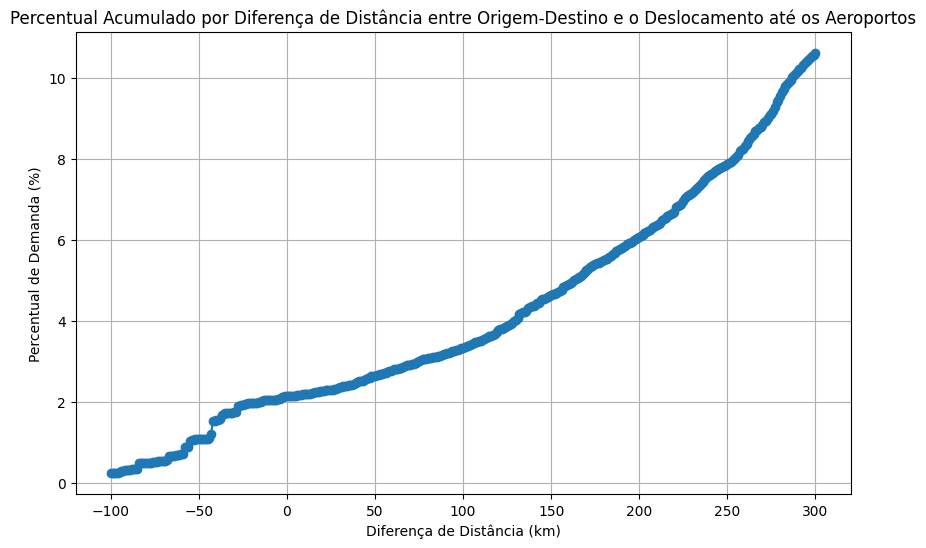

In [152]:
# Definição dos valores globais
INICIO = -100
FIM = 300
PASSO = 1

def gerar_grafico_percentual_demanda_diferenca(matriz_od):
    # Definição da função para calcular o percentual
    def calcular_percentual_demanda(matriz_od, limite_diferenca):
        demanda_total = matriz_od['demanda_aerea_previsto'].sum()
        demanda_filtrada = matriz_od[
            (matriz_od['distancia_mun_mun'] - matriz_od['distancia_mun_aero_origem'] + matriz_od['distancia_mun_aero_destino']) <= limite_diferenca
        ]['demanda_aerea_previsto'].sum()
        percentual = (demanda_filtrada / demanda_total) * 100 if demanda_total > 0 else 0
        return percentual

    # Intervalos de limite de diferença
    limites_diferenca = range(INICIO, FIM + 1, PASSO)

    # Calculando percentuais para cada limite de diferença
    percentuais_demanda = [calcular_percentual_demanda(matriz_od, limite) for limite in limites_diferenca]

    # Plotando o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(limites_diferenca, percentuais_demanda, marker='o', linestyle='-')
    plt.title('Percentual Acumulado por Diferença de Distância entre Origem-Destino e o Deslocamento até os Aeroportos')
    plt.xlabel('Diferença de Distância (km)')
    plt.ylabel('Percentual de Demanda (%)')
    plt.grid()

    # Exibir o gráfico
    plt.show()

# Chamada da função
gerar_grafico_percentual_demanda_diferenca(matriz_od_piar_revisado)

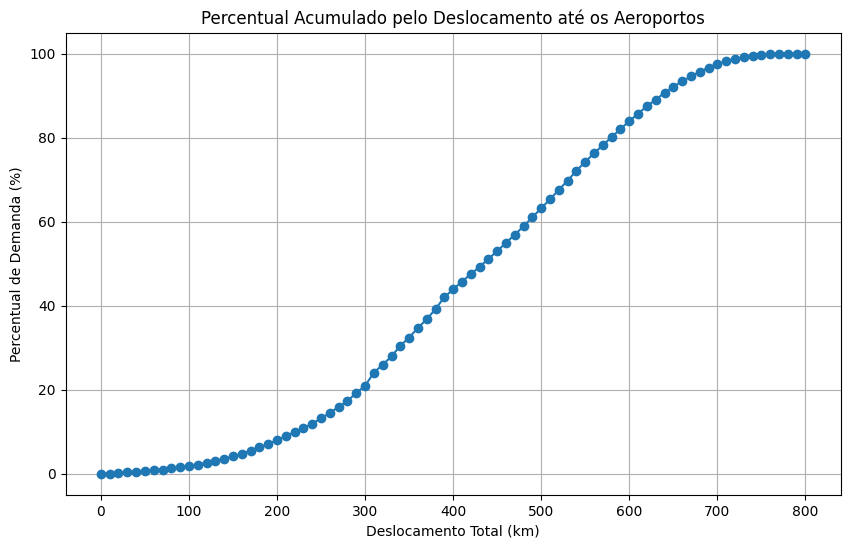

In [153]:
# Definição dos valores globais
INICIO = 0
FIM = 800
PASSO = 10

def gerar_grafico_percentual_demanda_deslocamento(matriz_od):
    # Definição da função para calcular o percentual
    def calcular_percentual_demanda(matriz_od, limite_diferenca):
        demanda_total = matriz_od['demanda_aerea_previsto'].sum()
        demanda_filtrada = matriz_od[
            (matriz_od['distancia_mun_aero_origem'] + matriz_od['distancia_mun_aero_destino']) <= limite_diferenca
        ]['demanda_aerea_previsto'].sum()
        percentual = (demanda_filtrada / demanda_total) * 100 if demanda_total > 0 else 0
        return percentual

    # Intervalos de limite de diferença
    limites_diferenca = range(INICIO, FIM + 1, PASSO)

    # Calculando percentuais para cada limite de diferença
    percentuais_demanda = [calcular_percentual_demanda(matriz_od, limite) for limite in limites_diferenca]

    # Plotando o gráfico
    plt.figure(figsize=(10, 6))
    plt.plot(limites_diferenca, percentuais_demanda, marker='o', linestyle='-')
    plt.title('Percentual Acumulado pelo Deslocamento até os Aeroportos')
    plt.xlabel('Deslocamento Total (km)')
    plt.ylabel('Percentual de Demanda (%)')
    plt.grid()

    # Exibir o gráfico
    plt.show()

# Chamada da função
gerar_grafico_percentual_demanda_deslocamento(matriz_od_piar_revisado)

In [208]:
def filtrar_matriz_od_piar(matriz_od):
    filtro = (
        (matriz_od['distancia_mun_aero_origem'] + matriz_od['distancia_mun_aero_destino'] <= 200) &
        (matriz_od['distancia_mun_mun'] - 
         (matriz_od['distancia_mun_aero_origem'] + matriz_od['distancia_mun_aero_destino']) >= 200)
    )
    return matriz_od[filtro]

# Aplicando a função
matriz_od_piar_final = filtrar_matriz_od_piar(matriz_od_piar_revisado)

In [209]:
def calcular_demanda_aerea_efetivo(matriz_od):
    matriz_od.loc[:, 'demanda_aerea_efetivo'] = (
        ((matriz_od['absorcao_origem'] / 100) + (matriz_od['absorcao_destino'] / 100)) / 2
    ) * matriz_od['demanda_aerea_previsto']
    return matriz_od

# Aplicando a função
matriz_od_piar_final = calcular_demanda_aerea_efetivo(matriz_od_piar_final)

C:\Users\ecpro_ygnml4q\AppData\Local\Temp\ipykernel_13048\487705786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matriz_od.loc[:, 'demanda_aerea_efetivo'] = (


In [210]:
def criar_matriz_od_piar_resumo(matriz_od):
    # Selecionar as colunas relevantes
    colunas_selecionadas = ['rota', 'cenario', 'aero_origem', 'aero_destino', 
                             'demanda_aerea_previsto', 'demanda_aerea_efetivo']
    matriz_resumo = matriz_od[colunas_selecionadas]

    # Agrupar por rota, cenário, aeroporto de origem e destino, somando as demandas
    matriz_resumo = matriz_resumo.groupby(['rota', 'cenario', 'aero_origem', 'aero_destino'], as_index=False).sum()

    return matriz_resumo

# Aplicando a função
matriz_od_piar_resumo = criar_matriz_od_piar_resumo(matriz_od_piar_final)

In [ ]:
def criar_matriz_od_piar_resumo_rota(matriz_od):
    # Selecionar as colunas relevantes
    colunas_selecionadas = ['rota', 'cenario', 'demanda_aerea_previsto', 'demanda_aerea_efetivo']
    matriz_resumo = matriz_od[colunas_selecionadas]

    # Agrupar por rota e cenário, somando as demandas
    matriz_resumo = matriz_resumo.groupby(['rota', 'cenario'], as_index=False).sum()

    return matriz_resumo

# Aplicando a função
matriz_od_piar_resumo_rota = criar_matriz_od_piar_resumo_rota(matriz_od_piar_final)

In [212]:
matriz_od_piar_resumo_rota.head()

,rota,cenario,demanda_aerea_previsto,demanda_aerea_efetivo
0,A,1,446484.606959,277752.428238
1,A,2,446010.782416,277802.121034
2,B,1,100987.521434,70556.121070
3,B,2,106473.506865,74224.820864


In [213]:
matriz_od_piar_final.to_excel('data/excel/xlsx/matriz_od_piar.xlsx', index = False)